### Importando Bibliotecas a serem utilizadas

In [244]:
import yfinance as yf
import pandas as pd
from bcb import sgs, currency
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Criando as tabelas

Utilizando a biblioteca Python 'yfinance' que possui os dados diários através do link(https://finance.yahoo.com/quote/%5EBVSP/history/)

O Yahoo Finance utiliza 5 colunas relativas a preço do ativos:

- Open -> Preço de abertura do dia do ativo (sem ajuste).
- High -> Maior preço alcançado no dia pelo ativo (sem ajuste).
- Low -> Menor preço alcançado no dia pelo ativo (sem ajuste).
- Close -> Preço de fechamento do dia do ativo (sem ajuste).
- Adj Close -> Preço de fechamento do dia do ativo (com ajuste) ##  Com o preço de fechamento, você verá apenas a mudança bruta no preço, enquanto o preço de fechamento ajustado também levará em consideração o dividendo. Para ações que não pagam dividendos, não haverá diferença entre esses dois valores.
- Volume -> Número de negócios que teve no dia.

In [245]:
#Importando os dados
start_date = '2021-05-06'
end_date = '2024-07-12'

df_origem = yf.download('^BVSP', start=start_date, end=end_date)
df_origem.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-06,119577.0,119966.0,119071.0,119921.0,119921.0,8779600
2021-05-07,119922.0,122038.0,119922.0,122038.0,122038.0,8865100
2021-05-10,122038.0,122772.0,121795.0,121909.0,121909.0,8219100
2021-05-11,121904.0,122964.0,120145.0,122964.0,122964.0,7988600
2021-05-12,122964.0,122964.0,119458.0,119710.0,119710.0,9405200


In [246]:
# Indice S&P/B3 Ibovespa VIX -> Avaliação de risco
df_vix = pd.read_excel('PerformanceGraphExport.xlsx')

In [247]:
df_vix = df_vix.set_index('Data efetiva')
df_vix.head()

,S&P/B3 Ibovespa VIX
Data efetiva,
2021-05-06,25.70
2021-05-07,24.01
2021-05-10,23.85
2021-05-11,24.97
2021-05-12,26.94


In [248]:
# Importando dados SELIC
selic_df = sgs.get(('selic', 432), start= '2021-05-06', end='2024-07-12')

selic_df.head()

,selic
Date,
2021-05-06,3.5
2021-05-07,3.5
2021-05-08,3.5
2021-05-09,3.5
2021-05-10,3.5


In [249]:
# Importando dados da taxa DOLAR
usd_brl = yf.download('BRL=X', start= '2021-05-06', end='2024-07-12')
usd_brl = usd_brl[['Close']].rename(columns={'Close':'Dollar'})
usd_brl.head()                                            

[*********************100%%**********************]  1 of 1 completed


,Dollar
Date,
2021-05-06,5.352700
2021-05-07,5.273431
2021-05-10,5.235500
2021-05-11,5.222200
2021-05-12,5.221200


In [250]:
def tabela_unica(df, df_juncao):
    df_novo = df.merge(df_juncao, how = 'left',  left_on = df_origem.index, right_on = df_juncao.index)
    df_novo.rename(columns={'key_0':'Date'}, inplace = True)
    df_novo = df_novo.set_index('Date')

    return df_novo

In [251]:
#Criando as tabelas
#VIX 
df_ibov_vix = tabela_unica(df_origem, df_vix)

#VIX + Selic
df_ibov_selic = tabela_unica(df_ibov_vix, selic_df)

#VIX + Selic + Dolar
df_ibov = tabela_unica(df_ibov_selic, usd_brl)

df_ibov.head()

,Open,High,Low,Close,Adj Close,Volume,S&P/B3 Ibovespa VIX,selic,Dollar
Date,,,,,,,,,
2021-05-06,119577.0,119966.0,119071.0,119921.0,119921.0,8779600,25.70,3.5,5.352700
2021-05-07,119922.0,122038.0,119922.0,122038.0,122038.0,8865100,24.01,3.5,5.273431
2021-05-10,122038.0,122772.0,121795.0,121909.0,121909.0,8219100,23.85,3.5,5.235500
2021-05-11,121904.0,122964.0,120145.0,122964.0,122964.0,7988600,24.97,3.5,5.222200
2021-05-12,122964.0,122964.0,119458.0,119710.0,119710.0,9405200,26.94,3.5,5.221200


In [252]:
#Fechamento vs as demais variáveis
df_close = df_ibov[['Close', 'Volume', 'S&P/B3 Ibovespa VIX', 'selic', 'Dollar']]

In [253]:
df_close.head()

,Close,Volume,S&P/B3 Ibovespa VIX,selic,Dollar
Date,,,,,
2021-05-06,119921.0,8779600,25.70,3.5,5.352700
2021-05-07,122038.0,8865100,24.01,3.5,5.273431
2021-05-10,121909.0,8219100,23.85,3.5,5.235500
2021-05-11,122964.0,7988600,24.97,3.5,5.222200
2021-05-12,119710.0,9405200,26.94,3.5,5.221200


### Análise exploratória dos dados

In [254]:
df_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 795 entries, 2021-05-06 to 2024-07-11
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Close                795 non-null    float64
 1   Volume               795 non-null    int64  
 2   S&P/B3 Ibovespa VIX  795 non-null    float64
 3   selic                795 non-null    float64
 4   Dollar               794 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 37.3 KB


In [255]:
#Quantidade de duplicados
print('Volume de duplicados na amostra: ', df_close.duplicated().sum())

Volume de duplicados na amostra:  0


In [256]:
#Estatistica descritiva
df_close.describe()

,Close,Volume,S&P/B3 Ibovespa VIX,selic,Dollar
count,795.000000,7.950000e+02,795.000000,795.000000,794.000000
mean,115352.857862,1.140796e+07,22.662101,11.102201,5.137218
std,8982.248671,3.366115e+06,4.618932,3.125273,0.232318
min,96121.000000,0.000000e+00,13.620000,3.500000,4.593800
25%,108460.000000,9.395250e+06,18.935000,10.500000,4.956725
50%,114474.000000,1.120350e+07,22.490000,12.250000,5.133900
75%,122704.000000,1.321720e+07,25.890000,13.750000,5.269125
max,134194.000000,2.602930e+07,35.390000,13.750000,5.744000


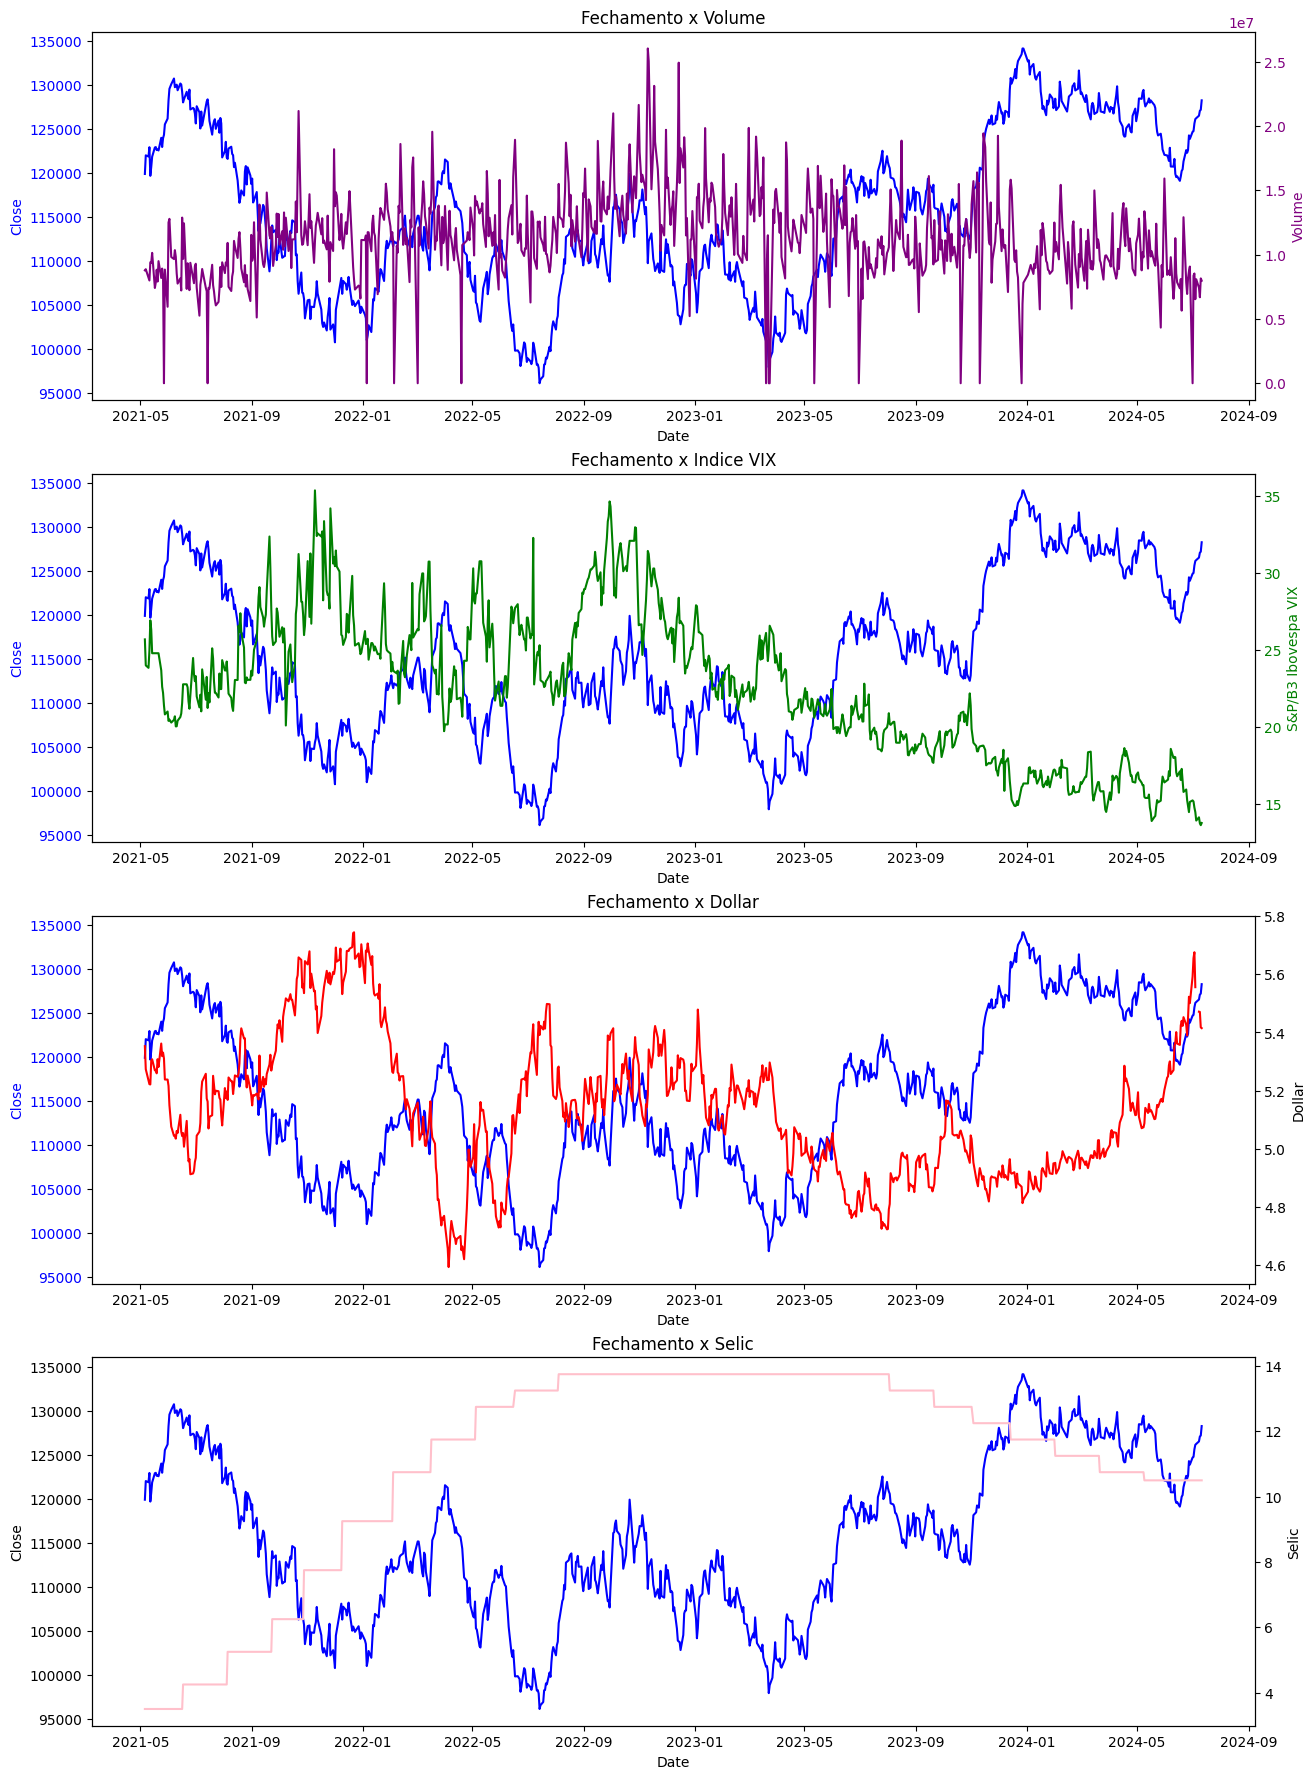

In [257]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (15, 22))
###Gráfico 3 Volume
ax1.plot(df_close.index, df_close['Close'], color='blue', label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Volume
ax5 = ax1.twinx()
ax5.plot(df_close.index, df_close['Volume'], color='purple', label='Volume')
ax5.set_ylabel('Volume', color='purple')
ax5.tick_params(axis='y', labelcolor='purple')


###Gráfico 3 vix
ax2.plot(df_close.index, df_close['Close'], color='blue', label='Close Price')
ax2.set_xlabel('Date')
ax2.set_ylabel('Close', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
plt.title('Fechamento x Volume')

# VIX
ax5 = ax2.twinx()
ax5.plot(df_close.index, df_close['S&P/B3 Ibovespa VIX'], color='green', label='HS&P/B3 Ibovespa VIX')
ax5.set_ylabel('S&P/B3 Ibovespa VIX', color='green')
ax5.tick_params(axis='y', labelcolor='green')
plt.title('Fechamento x Indice VIX')

###Gráfico 3 Dolar
# Fechamento x vix
ax3.plot(df_close.index, df_close['Close'], color='blue', label='Close Price')
ax3.set_xlabel('Date')
ax3.set_ylabel('Close', color='blue')
ax3.tick_params(axis='y', labelcolor='blue')

# Dollar
ax5 = ax3.twinx()
ax5.plot(df_close.index, df_close['Dollar'], color='red', label='Dollar')
ax5.set_ylabel('Dollar', color='black')
ax5.tick_params(axis='y', labelcolor='black')
plt.title('Fechamento x Dollar')

###Gráfico 4 Selic
ax4.plot(df_close.index, df_close['Close'], color='blue', label='Close Price')
ax4.set_xlabel('Date')
ax4.set_ylabel('Close', color='black')
ax4.tick_params(axis='y', labelcolor='black')

# Volume
ax5 = ax4.twinx()
ax5.plot(df_close.index, df_close['selic'], color='pink', label='Selic')
ax5.set_ylabel('Selic', color='black')
ax5.tick_params(axis='y', labelcolor='black')
plt.title('Fechamento x Selic')

#fig.suptitle('Variáveis')
plt.show()

<Axes: >

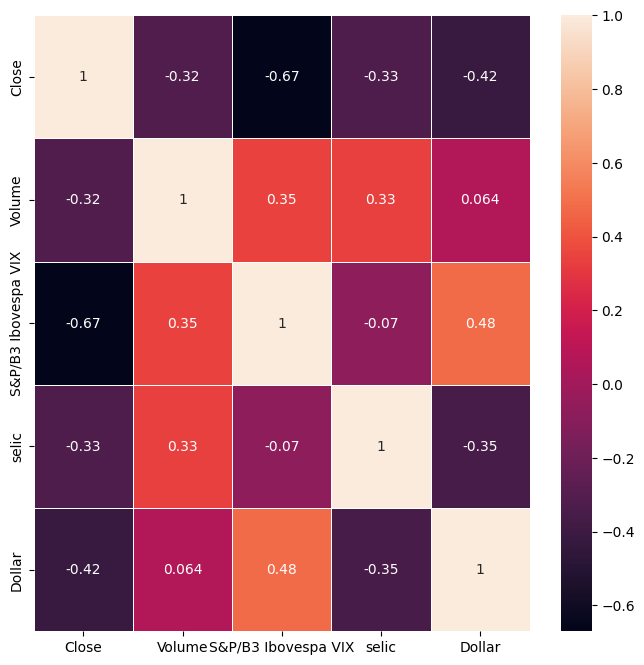

In [258]:
#Cria a matriz de correlação
correlation_matrix = df_close.corr()

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax)

### **AutoARIMA**

Para gerar previsões precisas em séries temporais, utilizaremos o AutoARIMA, um dos modelos disponíveis na biblioteca StatsForecast que suporta variáveis exógenas. O AutoARIMA é particularmente útil por sua capacidade de determinar automaticamente os melhores parâmetros ARIMA para o modelo, com base nos dados fornecidos.

#### Preparação dos Dados para Modelagem com AutoARIMA

Antes de aplicarmos o modelo AutoARIMA, é essencial preparar nossos dados de séries temporais seguindo convenções de nomenclatura específicas. Essas convenções não só facilitam a análise e o desenvolvimento de modelos de previsão como também asseguram a compatibilidade com bibliotecas especializadas em séries temporais.

Neste contexto, ajustamos os nomes das colunas para seguir as convenções padrão usadas em modelagem de séries temporais:


* A coluna `Date`, que indica a dimensão temporal (data/hora) de cada observação, será renomeada para `ds`.
* A coluna `Close`, que representa a variável alvo (target) que desejamos prever, será renomeada para `y`.

Além disso, para a biblioteca StatsForecast, adicionaremos uma coluna `unique_id` que serve como um identificador único para a série temporal.

In [259]:
# Criando uma cópia do dataframe original
df_auto_arima = df_close.copy()
df_exog = df_close.copy()

# Renomeando o índice e resetando-o para que 'ds' seja uma coluna
df_auto_arima.reset_index(inplace=True)
df_auto_arima.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
df_auto_arima = df_auto_arima[['ds','y']]
df_auto_arima['unique_id'] = 'exogenas'

#### Preparação das Variáveis Exógenas para o Modelo AutoARIMA

Para enriquecer nosso modelo AutoARIMA e potencialmente melhorar as previsões, podemos incluir variáveis exógenas que influenciam a variável alvo. Essas variáveis podem ser indicadores econômicos, índices de mercado, entre outros fatores externos que têm impacto sobre os dados que estamos analisando. As variáveis são selecionadas com base na hipótese de que elas têm influência sobre a variável alvo (`Close`/ `y`).

In [260]:
df_exog.reset_index(inplace=True)
df_exog.rename(columns={'Date': 'ds'}, inplace=True)

# Seleção de variáveis exógenas
df_exog = df_exog[['ds', 'S&P/B3 Ibovespa VIX', 'Volume']]

df_exog['unique_id'] = 'exogenas'

#### Verificação e Ajuste do Tipo de Dados das Variáveis Exógenas

Antes de procedermos com a modelagem utilizando as variáveis exógenas, é essencial verificar e, se necessário, ajustar o tipo de dados das colunas do DataFrame `df_exog`. Isso garante que as variáveis estejam no formato correto para serem utilizadas pelo modelo AutoARIMA, evitando erros durante a execução.

In [261]:
df_exog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 795 entries, 0 to 794
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ds                   795 non-null    datetime64[ns]
 1   S&P/B3 Ibovespa VIX  795 non-null    float64       
 2   Volume               795 non-null    int64         
 3   unique_id            795 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 25.0+ KB


> Após a verificação, identificamos que a coluna `unique_id` precisa estar no formato de string (str) para ser compatível com as exigências do modelo AutoARIMA. Portanto, realizamos a conversão do tipo de dados dessa coluna para `str`.

In [262]:
# A unique_id necessita ser do tipo string. 
df_exog['unique_id'] = df_exog.unique_id.astype(str)

#### Separação dos Dados e Conjuntos de Treino e Teste

A divisão dos dados em conjuntos de treino e teste é uma etapa fundamental na modelagem de séries temporais, pois permite avaliar a capacidade de generalização do modelo em dados não vistos anteriormente. Para este projeto, adotaremos a proporção de 80% dos dados para treino e 20% para teste, seguindo as melhores práticas de modelagem.

Os dados foram coletados no período de **06/05/2021** até **05/07/2024**, totalizando **795 registros**. Com base na divisão de 80/20, **636 registros** serão alocados para o conjunto de treino, enquanto **159 registros** serão destinados ao conjunto de teste. O registro de número **636** marca o dia 22/11/2023 como o ponto de corte entre os conjuntos de treino e teste.

Além disso, definimos o horizonte `h` de previsão, que representa o número de períodos futuros que desejamos prever, equivalente ao número de datas únicas no conjunto de teste.

In [263]:
# Definição da Data de Divisão
split_date = '2023-11-22'

# Preparação dos Dados de Treino e Teste para a Variável Alvo (Y):
Y_train = df_auto_arima[df_auto_arima['ds'] < split_date].copy()
Y_test = df_auto_arima[df_auto_arima['ds'] >= split_date].copy()

# Cálculo do Horizonte de Previsão (h):
h = Y_test['ds'].nunique()

In [264]:
print(f'Dimensões do DataFrame de Treino: {Y_train.shape}')
print(f'Dimensões do DataFrame de Teste: {Y_test.shape}')

Dimensões do DataFrame de Treino: (636, 3)
Dimensões do DataFrame de Teste: (159, 3)


In [265]:
# Preparação dos Dados de Treino e Teste para as Variáveis Exógenas (X): 
X_train = df_exog[df_exog['ds'] < split_date].copy()
X_test = df_exog[df_exog['ds'] >= split_date].copy()

In [266]:
print(f'Dimensões do DataFrame de Treino: {X_train.shape}')
print(f'Dimensões do DataFrame de Teste: {X_test.shape}')

Dimensões do DataFrame de Treino: (636, 4)
Dimensões do DataFrame de Teste: (159, 4)


#### Adicionar Variáveis Exógenas ao Conjunto de Treino

As variáveis exógenas devem ser incorporadas ao conjunto de treino. Elas devem ser posicionadas após a variável alvo `y`. Isso garante que cada observação no conjunto de treino considere o impacto potencial das variáveis externas sobre a previsão.

In [267]:
train = Y_train.merge(X_train, how = 'left', on = ['unique_id', 'ds']) 
train

,ds,y,unique_id,S&P/B3 Ibovespa VIX,Volume
0,2021-05-06,119921.0,exogenas,25.70,8779600
1,2021-05-07,122038.0,exogenas,24.01,8865100
2,2021-05-10,121909.0,exogenas,23.85,8219100
3,2021-05-11,122964.0,exogenas,24.97,7988600
4,2021-05-12,119710.0,exogenas,26.94,9405200
...,...,...,...,...,...
631,2023-11-14,123328.0,exogenas,18.79,19427900
632,2023-11-16,124576.0,exogenas,18.51,18355600
633,2023-11-17,125062.0,exogenas,17.51,15719100
634,2023-11-20,126095.0,exogenas,17.67,11108500


#### Visualização dos Dados de Treinamento e Teste

Plotagem dos conjuntos de dados de treinamento e teste para observar como eles estão distribuídos ao longo do tempo.

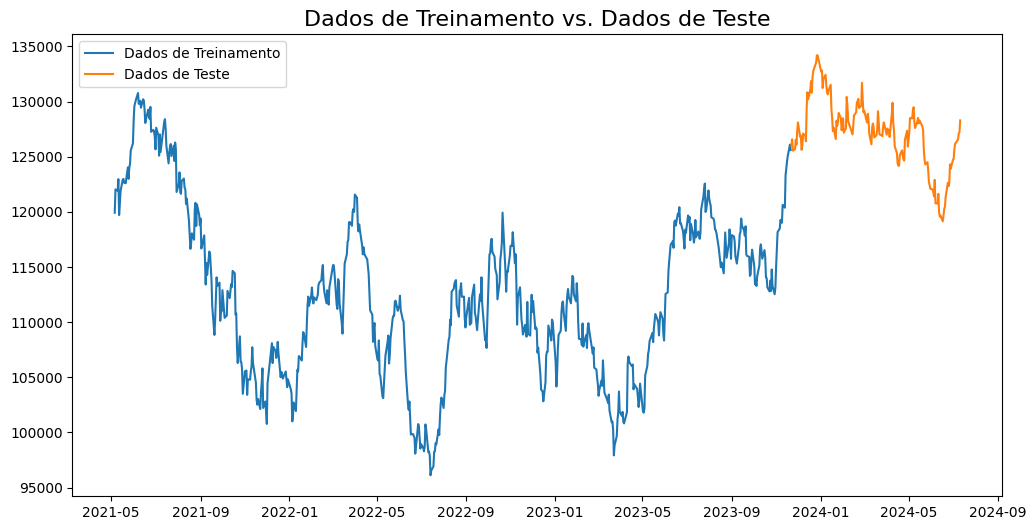

In [268]:
plt.figure(figsize=(12, 6))

# Plotagem dos dados de treino e teste
plt.plot(Y_train['ds'], Y_train['y'], label='Dados de Treinamento')
plt.plot(Y_test['ds'], Y_test['y'], label='Dados de Teste')

# Adição do título
plt.title('Dados de Treinamento vs. Dados de Teste', fontsize=16)
plt.legend()

plt.show()

#### Importação do StatsForecast e AutoARIMA para Modelagem de Séries Temporais

Para a modelagem de séries temporais com o modelo AutoARIMA, utilizamos a biblioteca StatsForecast, que oferece uma implementação eficiente e otimizada de diversos modelos de previsão de séries temporais, incluindo o AutoARIMA. 

In [269]:

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

#### Instanciação Modelo AutoARIMA

O modelo foi ajustado com os seguintes parâmetros:
* `season_length=5` (sazonalidade) para que o modelo considere padrões que se repetem a cada 5 períodos
* `freq='B'` (frequência) para que o modelo considere a frequência de dias úteis (excluindo fins de semana)
* `n_jobs=-1` (paralelização) para que todos os núcleos de CPU disponíveis sejam utilizados.

In [270]:
# Configuração do modelo AutoARIMA
model_auto_arima = StatsForecast(models=[AutoARIMA(season_length=5)], freq='B', n_jobs=-1)

#### Geração de Previsões com AutoARIMA

Após a configuração do modelo AutoARIMA, estamos prontos para gerar previsões. Para isso, utilizaremos o método `forecast`, que nos permite projetar valores futuros com base nos dados fornecidos. Esse método é flexível e aceita diversos argumentos que ajustam a forma como as previsões são geradas e apresentadas:

* `h`: Representa o horizonte de previsão. Neste caso, pretendemos prever definido anteriormente para a variável `h`, ou seja, o total do nosso conjunto de teste (`h = Y_test['ds'].nunique()`).
* `X_df`: Dataframe com os valores futuros das variáveis exógenas.
* `level`: Níveis de confiança dos intervalos de previsão.

In [271]:
# Realizando a previsão com valores ajustados e intervalo de confiança de 95%
df_hat = model_auto_arima.forecast(df=train, h=h, level=[95], X_df=X_test)

# Exibindo as previsões com intervalo de confiança
df_hat

d:\Cursos\FIAP\Data Analytics\Fase 02\Tech-Challenge-2\venv\Lib\site-packages\statsforecast\core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
unique_id,,,,
exogenas,2023-11-22,125661.375000,123207.281250,128115.468750
exogenas,2023-11-23,125603.609375,122274.429688,128932.789062
exogenas,2023-11-24,125518.789062,121491.234375,129546.343750
exogenas,2023-11-27,125458.421875,120837.539062,130079.304688
exogenas,2023-11-28,125835.664062,120689.359375,130981.968750
...,...,...,...,...
exogenas,2024-06-25,127259.281250,99041.171875,155477.390625
exogenas,2024-06-26,127164.890625,98855.992188,155473.796875
exogenas,2024-06-27,127332.757812,98933.367188,155732.156250


#### Visualização das Previsões com AutoARIMA COM Variáveis Exógenas

Uma vez que as previsões foram geradas, é útil visualizá-las para melhor compreender o comportamento projetado da série temporal e avaliar a qualidade das previsões. 

Os gráficos a seguir comparam os dados históricos com as previsões futuras, incluindo os intervalos de confiança, proporcionando uma visualização intuitiva do desempenho do modelo.

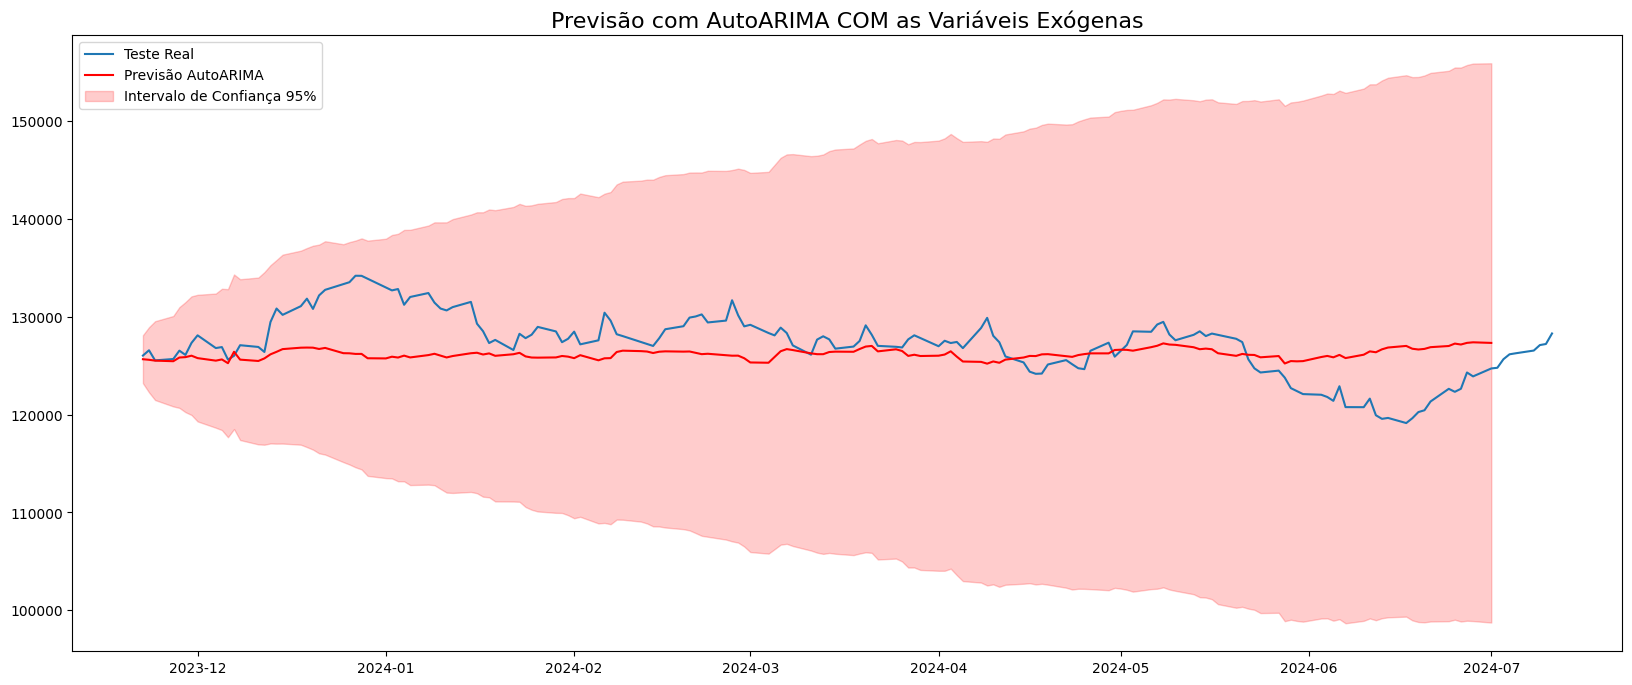

In [283]:
# Plotando os resultados
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

# Plotando os dados de teste e as previsões diretamente no eixo 'ax'
ax.plot(Y_test['ds'], Y_test['y'], label='Teste Real')
ax.plot(df_hat['ds'], df_hat['AutoARIMA'], label='Previsão AutoARIMA', color='red')

# Adicionando a área de confiança
ax.fill_between(df_hat['ds'], 
                df_hat['AutoARIMA-lo-95'], 
                df_hat['AutoARIMA-hi-95'],
                alpha=0.2, color='red', label='Intervalo de Confiança 95%')

# Configurando características do gráfico
ax.legend()
ax.set_title('Previsão com AutoARIMA COM as Variáveis Exógenas', fontsize=16)

# Exibindo o gráfico
plt.show()

### Avaliação do Modelo

Após treinar nosso modelo, é crucial avaliá-lo para entender o quão bem ele está performando. Utilizamos várias métricas de precisão comuns para julgar as previsões:

* **MAE (Erro Absoluto Médio)**: Mostra a diferença média entre as previsões e os valores reais, ignorando a direção. Quanto menor, melhor.
* **RMSE (Raiz do Erro Quadrático Médio)**: Semelhante ao MAE, mas dá mais peso aos erros grandes. Isso o torna particularmente útil quando grandes erros são indesejáveis.
* **MAPE (Erro Percentual Absoluto Médio)**: Expressa o erro como uma porcentagem do valor real. Útil para comparações diretas entre séries temporais de diferentes escalas.
* **R² (Coeficiente de Determinação)**: Indica a proporção da variação dos dados que é previsível pelo modelo. Valores mais próximos de 1 indicam um modelo muito bom.

In [273]:
from sklearn import metrics

def model_evaluation(y_true, y_pred, Model):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print (f'Avaliação do Modelo: {Model}')
    print(f'MAE: {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE: {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R²: {metrics.r2_score(y_true, y_pred)}')

#### Executando a Avaliação do Modelo AutoARIMA COM as Variáveis Exógenas

In [274]:
model_evaluation(Y_test["y"], df_hat["AutoARIMA"], "AutoARIMA")

Avaliação do Modelo: AutoARIMA
MAE: 2532.8040487421385
RMSE: 3181.8594000478897
MAPE: 1.9892709191249942
R²: -0.05388073253448211


#### Avaliando a Contribuição das Variáveis Exógenas

Para avaliar se as variáveis exógenas contribuíram significativamente para a precisão do nosso modelo AutoARIMA, realizaremos uma comparação gerando previsões sem a inclusão desses regressores. Isso envolve fornecer ao método forecast apenas os dados que incluem `unique_id`, `ds`, e `y`, sem as variáveis exógenas.

In [277]:
# Gerando previsões sem regressores exógenos
df_hat_u = model_auto_arima.forecast(df=train[['unique_id', 'ds', 'y']], h=h, level=[95])

d:\Cursos\FIAP\Data Analytics\Fase 02\Tech-Challenge-2\venv\Lib\site-packages\statsforecast\core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


#### Visualização das Previsões do AutoARIMA SEM as Variáveis Exógenas

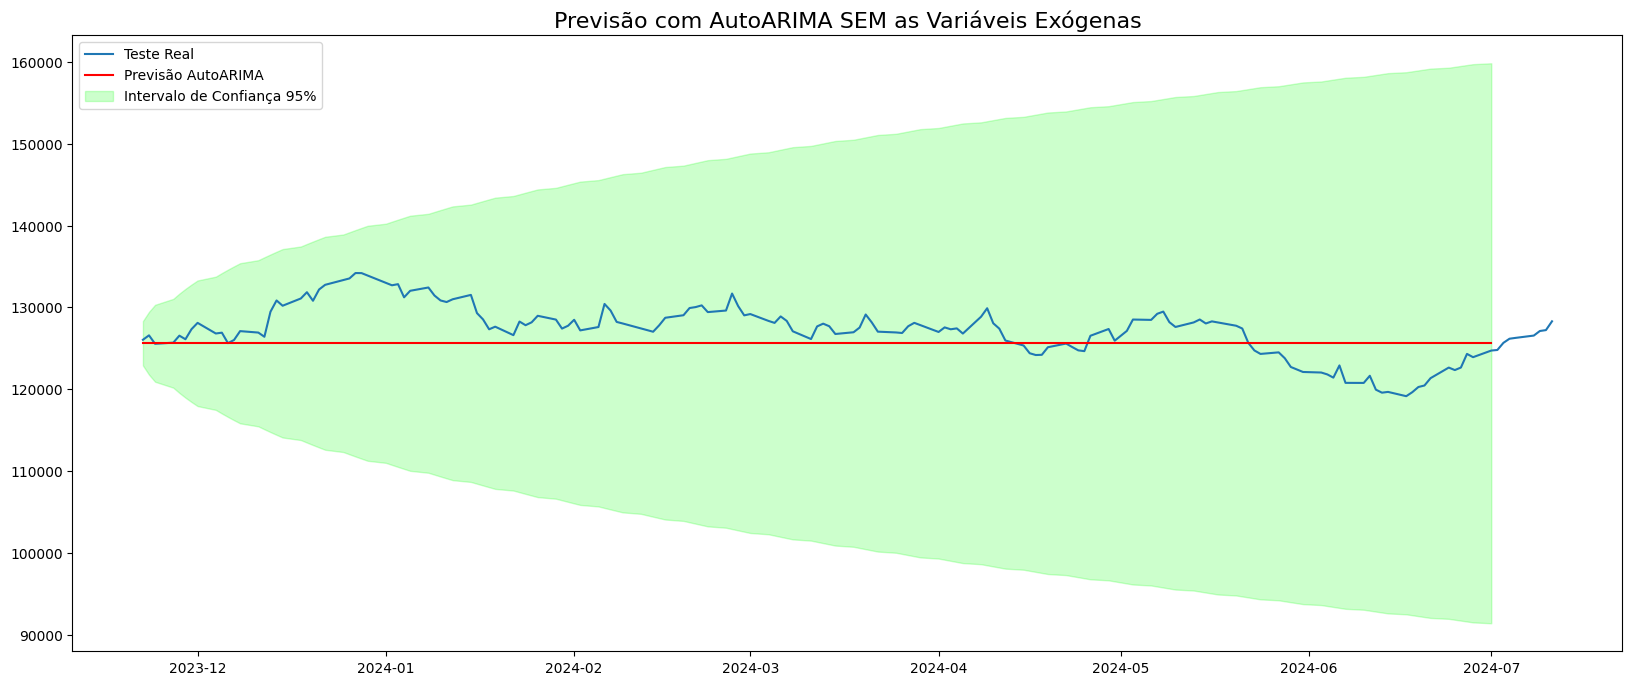

In [286]:
# Plotando os resultados
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

# Plotando os dados de teste e as previsões diretamente no eixo 'ax'
ax.plot(Y_test['ds'], Y_test['y'], label='Teste Real')
ax.plot(df_hat_u['ds'], df_hat_u['AutoARIMA'], label='Previsão AutoARIMA', color='red')

# Adicionando a área de confiança
ax.fill_between(df_hat_u['ds'], 
                df_hat_u['AutoARIMA-lo-95'], 
                df_hat_u['AutoARIMA-hi-95'],
                alpha=0.2, color='lime', label='Intervalo de Confiança 95%')

# Configurando características do gráfico
ax.legend()
ax.set_title('Previsão com AutoARIMA SEM as Variáveis Exógenas', fontsize=16)

# Exibindo o gráfico
plt.show()

#### Executando a Avaliação do Modelo AutoARIMA COM as Variáveis Exógenas

In [285]:
model_evaluation(Y_test["y"], df_hat_u["AutoARIMA"], "AutoARIMA")

Avaliação do Modelo: AutoARIMA
MAE: 2853.2264150943397
RMSE: 3454.9800434487215
MAPE: 2.233976618962293
R²: -0.24256918936707783


#### Análise os Indicadores

* **MAE, RMSE, e MAPE**: Todos são menores para o **Modelo AutoARIMA COM Variáveis Exógenas**, indicando que ele teve um melhor desempenho em termos de precisão das previsões.
* **R²**: Ambos os modelos têm valores negativos, o que não é ideal. No entanto, o **Modelo AutoARIMA COM Variáveis Exógenas** tem um valor menos negativo, indicando que ele está mais próximo de fazer previsões úteis do que o **Modelo AutoARIMA SEM Variáveis Exógenas**.

**Conclusão:** Com base nos indicadores fornecidos, o **Modelo AutoARIMA COM Variáveis Exógenas** teve um desempenho melhor do que o **Modelo AutoARIMA SEM Variáveis Exógenas** em todas as métricas avaliadas. Portanto, o Modelo **Modelo AutoARIMA COM Variáveis Exógenas** é o melhor dos dois.